In [13]:
import warnings
warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='imputation', key_added_pred='impute_mclust',
             random_seed=666):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """

    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(adata.obsm[used_obsm], num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs[key_added_pred] = mclust_res
    adata.obs[key_added_pred] = adata.obs[key_added_pred].astype('int')
    adata.obs[key_added_pred] = adata.obs[key_added_pred].astype('category')
    return adata


In [14]:
import STMGAC

In [15]:
proj_name = 'E9.5_E1S1'
num_clusters = 12

In [16]:
with open('../Config/ME9_5.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [17]:
adata = sc.read_h5ad(os.path.join(r"C:\Users\DELL\datasets\MouseEmbryo/" + proj_name + ".MOSTA.h5ad"))
adata.var_names_make_unique()

graph_dict = STMGAC.graph_construction(adata, config['data']['k_cutoff'])

adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count',
                            n_top_genes=config['data']['top_genes'])
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

In [18]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = STMGAC.Mgac(adata, graph_dict=graph_dict, num_clusters=num_clusters, device=device, config=config)

In [19]:
net.trian()

Epoch 499 total loss=0.618 recon loss=1.061 mean loss=0.469 tri loss=0.262: 100%|██████████| 500/500 [00:52<00:00,  9.61it/s]


In [20]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon


In [21]:
adata = mclust_R(adata, num_cluster=num_clusters, used_obsm='latent', key_added_pred='mclust')
sub_adata = adata[~pd.isnull(adata.obs['annotation'])]
ARI = ari_score(sub_adata.obs['annotation'], sub_adata.obs['mclust'])

fitting ...
  |======================================================================| 100%


In [22]:
adata.obs["mclust"] = adata.obs["mclust"].values.astype(str)
adata.layers["recon"] = adata.obsm["recon"]

In [23]:
Marker_Genes_Dict = {
    "Brain": ["Pax6", "Neurog2"],
    "Neural crest": ["Flrt2", "Fbn2"],
    "Sclerotome": ["Pcp4"],
    "Dermomyotome": ["Myog"],
    "Mesenchyme": ["Mylpf", "Meox1"],
    "Heart": ["Myl7", "Tnnt2"],
}

categories: 1, 2, 3, etc.
var_group_labels: Brain, Neural crest, Sclerotome, etc.


{'mainplot_ax': <Axes: >,
 'group_extra_ax': <Axes: >,
 'gene_group_ax': <Axes: >,
 'color_legend_ax': <Axes: title={'center': 'Median expression\nin group'}>}

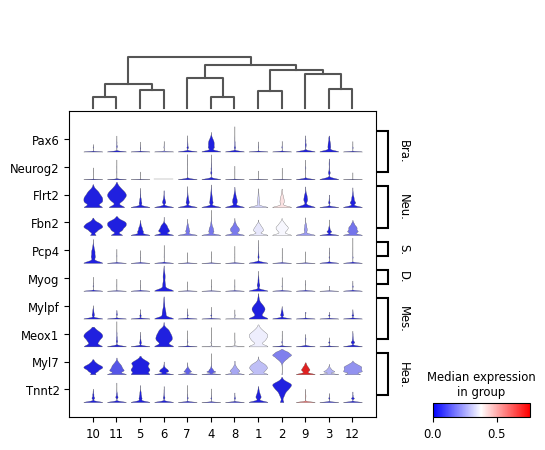

In [24]:
sc.pl.stacked_violin(adata, Marker_Genes_Dict, groupby='mclust', show=False, cmap='bwr', swap_axes=True,
                     dendrogram=True, standard_scale='var', layer='count', save=False)

categories: 1, 2, 3, etc.
var_group_labels: Brain, Neural crest, Sclerotome, etc.


{'mainplot_ax': <Axes: >,
 'group_extra_ax': <Axes: >,
 'gene_group_ax': <Axes: >,
 'color_legend_ax': <Axes: title={'center': 'Median expression\nin group'}>}

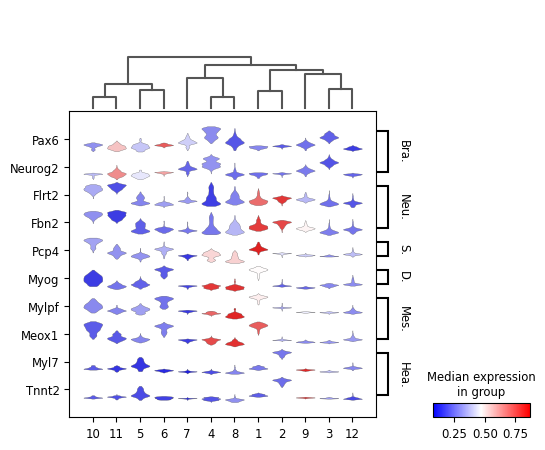

In [25]:
sc.pl.stacked_violin(adata, Marker_Genes_Dict, groupby='mclust', show=False, cmap='bwr', swap_axes=True,
                     dendrogram=True, standard_scale='var', layer='recon', save=False)